In [1]:
import torch
from collections import OrderedDict

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.rcParams['pgf.texsystem'] = 'pdflatex'
# matplotlib.rcParams.update({'font.family': 'serif', 'font.size': 10})
# matplotlib.rcParams['text.usetex'] = True
from matplotlib.lines import Line2D
import os
import pickle

from scipy.interpolate import griddata
import time

np.random.seed(1234)

## Overview

This jupyter notebook implements the time-consistent physics-informed neural network (tcPINN) idea for the planar three-body problem, restricted to solutions with constant barycenter. Without loss of generality, the domain of intial values can be further reduced by exploiting the roation and scale invariance of the ODE system.

Although the training loss is reduced by two orders of magnitude training compared to the naive three-body problem implemenation, the tcPINN is still unable to completely learn the dynamics for this restricted domain of initial values. That is, the PINN loss does not converge to zero.

A more comprehensive discussion of the problem is given in $\texttt{three_body_problem_naive.ipynb}$ and in the report.

Consider three gravitationally interacting identical bodies with positions $r_i(t) \in \mathbb{R}^2$. Assuming a gravitational force of $G=1$, the Newtonian equations governing their motion reads

\begin{align*}
    \frac{d^2}{dt^2} \begin{pmatrix} r_1(t) \\ r_2(t) \\ r_3(t) \end{pmatrix} = \begin{pmatrix} - \frac{r_1(t) - r_2(t)}{|r_1(t) - r_2(t)|^3} - \frac{r_1(t) - r_3(t)}{|r_1(t) - r_3(t)|^3} \\ - \frac{r_2(t) - r_1(t)}{|r_2(t) - r_1(t)|^3} - \frac{r_2(t) - r_3(t)}{|r_2(t) - r_3(t)|^3} \\ - \frac{r_3(t) - r_1(t)}{|r_3(t) - r_1(t)|^3} - \frac{r_3(t) - r_2(t)}{|r_3(t) - r_2(t)|^3} \end{pmatrix}.
\end{align*}

Notice that the ODE implies

\begin{align*}
    \sum_{i=1}^3 \frac{d^2}{dt^2} r_i(t) = 0,
\end{align*}

which yields

\begin{align*}
    \sum_{i=1}^3 \frac{d}{dt} r_i(t) = \overrightarrow{C}_1 = \sum_{i=1}^3 \frac{d}{dt} r_i(0),
\end{align*}

and

\begin{align*}
    \sum_{i=1}^3 r_i(t) = \overrightarrow{C}_1 t + \overrightarrow{C}_2
\end{align*}

with 

\begin{align*}
    \overrightarrow{C}_2 = \sum_{i=1}^3 r_i(0).
\end{align*}

That is, the barycenter of the three bodies moves on a straight line. By restricting ourselves to initial conditions with mean location and velocity equal to the origin, we enforce the solution to have a constant barycenter over time, i.e.

\begin{align*}
    \sum_{i=1}^3 r_i(t) = 0.
\end{align*}

Both the location and the velocity of the thrid particle can then be obtained by the symmetry of the system:

\begin{align}
    r_3(t) &= - (r_1(t) + r_2(t)), \\
    v_3(t) &= - (v_1(t) + v_2(t))
\end{align}

An even stronger assumption on the initial conditions was used in [1] to simplify the training task. Under this assumption, we can plug the formula for $r_3$ into the original ODE system to obtain

\begin{align*}
    \frac{d^2}{dt^2} \begin{pmatrix} r_1 \\ r_2 \end{pmatrix} = \begin{pmatrix} - \frac{r_1 - r_2}{|r_1 - r_2|^3} - \frac{2r_1 + r_2}{|2r_1 + r_2|^3} \\ - \frac{r_2 - r_1}{|r_2 - r_1|^3} - \frac{2r_2 + r_1}{|2r_2 + r_1|^3} \end{pmatrix}.
\end{align*}

This is a second-order ODE system of $4$ equations. By introducing the velocities $v_i(t) = \frac{d}{dt}r_i(t)$, it can be rewritten as the following first-order ODE system of $8$ equations:

\begin{align*}
    \frac{d}{dt} \begin{pmatrix} r_1 \\ r_2 \\ v_1 \\ v_2 \end{pmatrix} = \begin{pmatrix} v_1 \\ v_2 \\ - \frac{r_1 - r_2}{|r_1 - r_2|^3} - \frac{2r_1 + r_2}{|2r_1 + r_2|^3} \\ - \frac{r_2 - r_1}{|r_2 - r_1|^3} - \frac{2r_2 + r_1}{|2r_2 + r_1|^3} \end{pmatrix}.
\end{align*}

For completeness, all $8$ equations with written-out components are

\begin{align*}
    \frac{d}{dt} \begin{pmatrix} r_{11} \\ r_{12} \\ r_{21} \\ r_{22} \\ v_{11} \\ v_{12} \\ v_{21} \\ v_{22} \end{pmatrix} = \begin{pmatrix} 
    v_{11} \\ v_{12} \\ v_{21} \\ v_{22} \\ 
    - \frac{r_{11} - r_{21}}{|r_1 - r_2|^3} - \frac{2r_{11} + r_{21}}{|2r_1 + r_2|^3} \\
    - \frac{r_{12} - r_{22}}{|r_1 - r_2|^3} - \frac{2r_{12} + r_{22}}{|2r_1 + r_2|^3} \\
    - \frac{r_{21} - r_{11}}{|r_2 - r_1|^3} - \frac{2r_{21} + r_{11}}{|2r_2 + r_1|^3} \\
    - \frac{r_{22} - r_{12}}{|r_2 - r_1|^3} - \frac{2r_{22} + r_{12}}{|2r_2 + r_1|^3}
\end{pmatrix}.
\end{align*}

With the notation $y = (r_{11}, r_{12}, r_{21}, r_{22}, v_{11}, v_{12}, v_{21}, v_{22})$ used in the implementation, the system reads

\begin{align*}
    \frac{d}{dt} y = \begin{pmatrix} 
    y_4 \\ y_5 \\ y_6 \\ y_7 \\ 
    - \frac{y_0 - y_2}{((y_0 - y_2)^2 + (y_1 - y_3)^2)^{3/2}} - \frac{2y_0 + y_2}{((2y_0 + y_2)^2 + (2y_1 + y_3)^2)^{3/2}} \\
    - \frac{y_1 - y_3}{((y_0 - y_2)^2 + (y_1 - y_3)^2)^{3/2}} - \frac{2y_1 + y_3}{((2y_0 + y_2)^2 + (2y_1 + y_3)^2)^{3/2}} \\
    - \frac{y_2 - y_0}{((y_0 - y_2)^2 + (y_1 - y_3)^2)^{3/2}} - \frac{2y_2 + y_0}{((2y_2 + y_0)^2 + (2y_3 + y_1)^2)^{3/2}} \\
    - \frac{y_3 - y_1}{((y_0 - y_2)^2 + (y_1 - y_3)^2)^{3/2}} - \frac{2y_3 + y_1}{((2y_2 + y_0)^2 + (2y_3 + y_1)^2)^{3/2}}
\end{pmatrix}.
\end{align*}

Due to rotational and scalar symmetry, we can assume

\begin{align*}
    r_1(0) = \begin{pmatrix} 1 \\ 0 \end{pmatrix}
\end{align*}

without loss of generality.

The barycenter of the three particles being equal to the origin of the coordinate system further allows us to assume

\begin{align*}
    \| r_2(0) - \begin{pmatrix} -1 \\ 0 \end{pmatrix} \| \leq 1
\end{align*}

and

\begin{align*}
    -0.5 &\leq r_{21}(0) \\
    0 &\leq r_{22}(0).
\end{align*}

Notice that the authors of [1] used an even stronger assumption by additionally setting all initial velocities to zero to simplify the training task.

In [2]:
# rejection sampling of the intial value of the second body
def sample_r2_init(N):
    
    samples = np.empty((N, 2))
    
    count = 0
    
    while count < N:
        
        length = np.sqrt(np.random.uniform(0, 1))
        angle = np.pi * np.random.uniform(0, 2)
        
        r21 = length * np.cos(angle)
        r22 = length * np.sin(angle)
        
        cond1 = (r21 + 1)**2 + r22**2 < 1
        cond2 = r21 > -.5
        cond3 = r22 > 0
        
        if cond1 and cond2 and cond3:
            
            samples[count, :] = [r21, r22]
            count += 1
    
    return samples

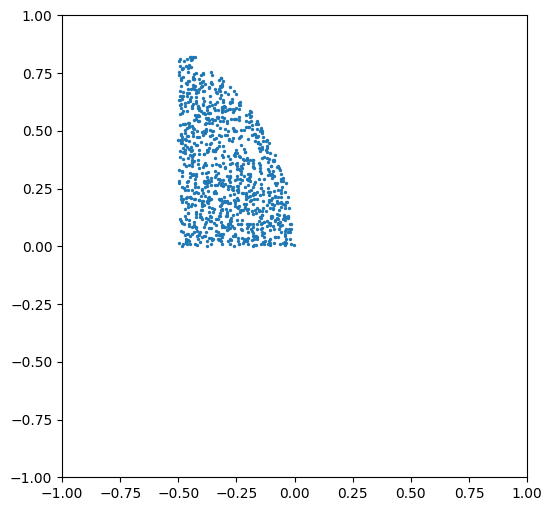

In [3]:
# demo of sample_r2_init
demo = sample_r2_init(1000)

fig = plt.figure(figsize=(6, 6))

plt.scatter(demo[:,0], demo[:,1], s=2)
plt.ylim([-1, 1])
plt.xlim([-1, 1])
plt.show()

In [4]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [5]:
# the deep neural network
class DNN(torch.nn.Module):
    
    def __init__(self, layers):
        
        super().__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        
        for i in range(self.depth - 1):
            
            linear_layer = torch.nn.Linear(layers[i], layers[i+1])
            torch.nn.init.xavier_normal_(linear_layer.weight, gain=5/3)
            torch.nn.init.zeros_(linear_layer.bias.data)
            
            layer_list.append(
                (f"layer_{i}", linear_layer)
            )
            layer_list.append((f"activation_{i}", self.activation()))
        
        last_layer = torch.nn.Linear(layers[-2], layers[-1])
        torch.nn.init.xavier_normal_(last_layer.weight)
        torch.nn.init.zeros_(last_layer.bias.data)
        
        layer_list.append(
            (f"layer_{self.depth - 1}", last_layer)
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
    
    
    def forward(self, x):
        
        # x = (t, y0)
        return self.layers(x)

In [6]:
# PINN: physics-informed neural network
class TcPINN():

    def __init__(self, X_pinn, X_semigroup, X_smooth, layers, T):

        # neural network architecture
        self.layers = layers
        self.dnn = DNN(layers).to(device)
        
        # semigroup PINN step time
        self.T = torch.tensor(T).float().to(device)

        # training data
        self.t_pinn = torch.tensor(X_pinn[:, :1], requires_grad=True).float().to(device)
        self.y_pinn = torch.tensor(X_pinn[:, 1:], requires_grad=True).float().to(device)
        
        self.s_semigroup = torch.tensor(X_semigroup[:, :1], requires_grad=True).float().to(device)
        self.t_semigroup = torch.tensor(X_semigroup[:, 1:2], requires_grad=True).float().to(device)
        self.y_semigroup = torch.tensor(X_semigroup[:, 2:], requires_grad=True).float().to(device)
        
        self.t_smooth = torch.tensor(X_smooth[:, :1], requires_grad=True).float().to(device)
        self.y_smooth = torch.tensor(X_smooth[:, 1:], requires_grad=True).float().to(device)
        
        # optimization
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), lr=1.0, max_iter=50000, max_eval=50000, 
            history_size=50, tolerance_grad=1e-5, tolerance_change=np.finfo(float).eps, 
            line_search_fn="strong_wolfe"
        )

        self.iter = 0
    
    
    def net_y(self, t, y0):
        
        # The M(t, y0) = y0 + t N(t, y0) scheme seems to drastically increase the accuracy
        # This works perfectly fine with automatic differentiation
        y = y0 + t * self.dnn(torch.cat([t, y0], dim=1))
        
        return y
    
    
    def net_derivative(self, t, y0):
        """
        Pytorch automatic differentiation to compute the derivative of the neural network
        """
        y = self.net_y(t, y0)
        
        # vectors for the autograd vector Jacobian product 
        # to compute the derivatives w.r.t. every output dimension
        vectors = [torch.zeros_like(y) for _ in range(8)]
        
        for i, vec in enumerate(vectors):
            
            vec[:,i] = 1.
        
        # list of derivative tensors
        # the first entry is a tensor with \partial_t PINN_0(t, y0) for all (t, y0) in the batch,
        # each input (t, y0) corresponds to one row in each tensor
        derivatives = [
            torch.autograd.grad(
                y, t, 
                grad_outputs=vec,
                retain_graph=True,
                create_graph=True
            )[0]
            for vec in vectors
        ]
        
        return derivatives
    
    
    def loss_function(self):
        
        self.optimizer.zero_grad()
        
        y_pred = self.net_y(self.t_pinn, self.y_pinn)
        deriv_pred = self.net_derivative(self.t_pinn, self.y_pinn)
        
        # This is specific to the ODE
        loss_pinn0 = torch.mean((deriv_pred[0] - y_pred[:,4:5]) ** 2)
        loss_pinn1 = torch.mean((deriv_pred[1] - y_pred[:,5:6]) ** 2)
        loss_pinn2 = torch.mean((deriv_pred[2] - y_pred[:,6:7]) ** 2)
        loss_pinn3 = torch.mean((deriv_pred[3] - y_pred[:,7:8]) ** 2)
        
        loss_pinn4 = torch.mean((deriv_pred[4] + (y_pred[:,0:1] - y_pred[:,2:3]) / ((y_pred[:,0:1] - y_pred[:,2:3])**2 + (y_pred[:,1:2] - y_pred[:,3:4])**2)**(3/2) + (2*y_pred[:,0:1] + y_pred[:,2:3]) / ((2*y_pred[:,0:1] + y_pred[:,2:3])**2 + (2*y_pred[:,1:2] + y_pred[:,3:4])**2)**(3/2)) ** 2)
        loss_pinn5 = torch.mean((deriv_pred[5] + (y_pred[:,1:2] - y_pred[:,3:4]) / ((y_pred[:,0:1] - y_pred[:,2:3])**2 + (y_pred[:,1:2] - y_pred[:,3:4])**2)**(3/2) + (2*y_pred[:,1:2] + y_pred[:,3:4]) / ((2*y_pred[:,0:1] + y_pred[:,2:3])**2 + (2*y_pred[:,1:2] + y_pred[:,3:4])**2)**(3/2)) ** 2)
        loss_pinn6 = torch.mean((deriv_pred[6] + (y_pred[:,2:3] - y_pred[:,0:1]) / ((y_pred[:,0:1] - y_pred[:,2:3])**2 + (y_pred[:,1:2] - y_pred[:,3:4])**2)**(3/2) + (2*y_pred[:,2:3] + y_pred[:,0:1]) / ((2*y_pred[:,2:3] + y_pred[:,0:1])**2 + (2*y_pred[:,3:4] + y_pred[:,1:2])**2)**(3/2)) ** 2)
        loss_pinn7 = torch.mean((deriv_pred[7] + (y_pred[:,3:4] - y_pred[:,1:2]) / ((y_pred[:,0:1] - y_pred[:,2:3])**2 + (y_pred[:,1:2] - y_pred[:,3:4])**2)**(3/2) + (2*y_pred[:,3:4] + y_pred[:,1:2]) / ((2*y_pred[:,2:3] + y_pred[:,0:1])**2 + (2*y_pred[:,3:4] + y_pred[:,1:2])**2)**(3/2)) ** 2)
        
        loss_pinn = loss_pinn0 + loss_pinn1 + loss_pinn2 + loss_pinn3 + loss_pinn4 + loss_pinn5 + loss_pinn6 + loss_pinn7
        
        # The general semigroup loss for autonomous ODEs
        y_pred_tps = self.net_y(self.s_semigroup + self.t_semigroup, self.y_semigroup)
        y_pred_s = self.net_y(self.s_semigroup, self.y_semigroup)
        y_pred_restart = self.net_y(self.t_semigroup, y_pred_s)
        loss_semigroup = torch.mean((y_pred_tps - y_pred_restart) ** 2)
        
        # The smoothness loss
        y_pred_smooth = self.net_y(self.t_smooth, self.y_smooth)
        deriv_pred_below = self.net_derivative(self.t_smooth, self.y_smooth)
        deriv_pred_above = self.net_derivative(torch.zeros_like(self.t_smooth, requires_grad=True), y_pred_smooth)
        
        loss_smooth = .0
        
        for t1, t2 in zip(deriv_pred_below, deriv_pred_above):
            
            loss_smooth += torch.mean((t1 - t2) ** 2)
        
        loss = loss_pinn + loss_smooth + loss_semigroup
        
        loss.backward()
        
        self.iter += 1
             
        if self.iter % 1 == 0:
            print(
                f"Iter {self.iter}, Loss: {loss.item():.5f}, Loss_pinn: {loss_pinn.item():.5f} " \
                f"Loss_smooth: {loss_smooth.item():.5f}, Loss_semigroup: {loss_semigroup.item():.5f}"
            )
        
        return loss
    
    
    def train(self):
        
        self.dnn.train()
        self.optimizer.step(self.loss_function)
        
        # save model checkpoint to allow further training
        state = {
                "state_dict": self.dnn.state_dict(),
                "optimizer": self.optimizer.state_dict()
            }
        torch.save(state, "./model_center_restricted_ivp")
    
    
    def predict(self, t, y0):
        
        t = torch.tensor(t, requires_grad=True).float().to(device)
        y0 = torch.tensor(y0, requires_grad=True).float().to(device)
        
        self.dnn.eval()
        y = self.net_y(t, y0)
        y = y.detach().cpu().numpy()
        
        return y

In [7]:
def load_checkpoint(model, filename):
    """
    Update the state of model.dnn and model.optimizer
    Usecase: Stop and restart the training process

    NOTE: When training with a GPU, the loaded models have to be moved to cuda
      see https://discuss.pytorch.org/t/loading-a-saved-model-for-continue-training/17244/2
    """   
    if os.path.isfile(filename):
        
        print(f"=> loading checkpoint '{filename}'")
        
        checkpoint = torch.load(filename)
        
        model.dnn.load_state_dict(checkpoint["state_dict"])
        model.optimizer.load_state_dict(checkpoint["optimizer"])
        model.dnn.train()
        
        print(f"=> loaded checkpoint '{filename}'")
    
    else:
        print(f"=> no checkpoint found at '{filename}'")

    return model

### Setup Training Data

In [10]:
layers = [9] + 15 * [128] + [8]


T = 1
max_v = 0.1

In [8]:
# standard PINN loss function training samples
N_pinn = 200000
N_semigroup = 50000
N_smooth = 50000


def sample_y(N, max_v):
    
    r1 = np.tile([1.,0.], (N,1))
    r2 = sample_r2_init(N)
    v = np.random.uniform(-max_v, max_v, (N, 4))
    
    return np.hstack([r1, r2, v])


t_pinn = np.random.uniform(0, T, (N_pinn, 1))
y_pinn = sample_y(N_pinn,  max_v)
X_pinn = np.hstack([t_pinn, y_pinn])


r1 = np.random.uniform(0, 1, N_semigroup)
r2 = np.random.uniform(0, 1, N_semigroup)
s_semigroup, t_semigroup = np.sqrt(r1) * (1 - r2), r2 * np.sqrt(r1)
s_semigroup, t_semigroup = T * s_semigroup[:, np.newaxis], T * t_semigroup[:, np.newaxis]
y_semigroup = sample_y(N_semigroup, max_v)
X_semigroup = np.hstack([s_semigroup, t_semigroup, y_semigroup])


t_smooth = np.random.uniform(0, T, (N_smooth, 1))
y_smooth = sample_y(N_smooth, max_v)
X_smooth = np.hstack([t_smooth, y_smooth])


with open("./X_pinn_center_restricted_ivp.pkl", "wb") as handle:
    pickle.dump(X_pinn, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("./X_semigroup_center_restricted_ivp.pkl", "wb") as handle:
    pickle.dump(X_semigroup, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open("./X_smooth_center_restricted_ivp.pkl", "wb") as handle:
    pickle.dump(X_smooth, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
model = TcPINN(X_pinn, X_semigroup, X_smooth, layers, T)

opt_sd = model.optimizer.state_dict()
opt_sd ['param_groups'][0]['max_iter'] = 50
model.optimizer.load_state_dict(opt_sd)

In [10]:
%%time
               
model.train()

Iter 1, Loss: 2766.70581, Loss_pinn: 2754.48486 Loss_smooth: 12.12974, Loss_semigroup: 0.09129
Iter 2, Loss: 4575.29053, Loss_pinn: 4563.13672 Loss_smooth: 12.06243, Loss_semigroup: 0.09131
Iter 3, Loss: 1816.97754, Loss_pinn: 1804.76294 Loss_smooth: 12.12324, Loss_semigroup: 0.09129
Iter 4, Loss: 1441.47412, Loss_pinn: 1429.25427 Loss_smooth: 12.12857, Loss_semigroup: 0.09130
Iter 5, Loss: 1426.77759, Loss_pinn: 1414.55859 Loss_smooth: 12.12773, Loss_semigroup: 0.09129
Iter 6, Loss: 1347.17371, Loss_pinn: 1334.96021 Loss_smooth: 12.12216, Loss_semigroup: 0.09125
Iter 7, Loss: 1233.59473, Loss_pinn: 1221.39209 Loss_smooth: 12.11142, Loss_semigroup: 0.09118
Iter 8, Loss: 1092.73633, Loss_pinn: 1080.54749 Loss_smooth: 12.09783, Loss_semigroup: 0.09112
Iter 9, Loss: 902.05908, Loss_pinn: 889.89832 Loss_smooth: 12.06982, Loss_semigroup: 0.09094
Iter 10, Loss: 895.09204, Loss_pinn: 883.02637 Loss_smooth: 11.97552, Loss_semigroup: 0.09014
Iter 11, Loss: 723.24933, Loss_pinn: 711.14673 Loss_s

In [12]:
n_training = 1
max_n_training = 15

In [13]:
# NOTE: When training with a GPU, the loaded models have to be moved to cuda
# see https://discuss.pytorch.org/t/loading-a-saved-model-for-continue-training/17244/2

with open("./X_pinn_center_restricted_ivp.pkl", "rb") as f:
    X_pinn = pickle.load(f)

with open("./X_semigroup_center_restricted_ivp.pkl", "rb") as f:
    X_semigroup = pickle.load(f)

with open("./X_smooth_center_restricted_ivp.pkl", "rb") as f:
    X_smooth = pickle.load(f)

while n_training < max_n_training:

    print(f"\nTraining run {n_training}")
    model = TcPINN(X_pinn, X_semigroup, X_smooth, layers, T)
    model = load_checkpoint(model, "model_center_restricted_ivp")

    opt_sd = model.optimizer.state_dict()
    opt_sd['param_groups'][0]['max_iter'] = 50
    opt_sd['param_groups'][0]['lr'] = 1
    model.optimizer.load_state_dict(opt_sd)
    model.train()
    n_training +=1 


Training run 1
=> loading checkpoint 'model_center_restricted_ivp'
=> loaded checkpoint 'model_center_restricted_ivp'
Iter 1, Loss: 0.48575, Loss_pinn: 0.46548 Loss_smooth: 0.01946, Loss_semigroup: 0.00082
Iter 2, Loss: 0.48545, Loss_pinn: 0.46508 Loss_smooth: 0.01955, Loss_semigroup: 0.00082
Iter 3, Loss: 0.49294, Loss_pinn: 0.47197 Loss_smooth: 0.02013, Loss_semigroup: 0.00085
Iter 4, Loss: 0.48535, Loss_pinn: 0.46515 Loss_smooth: 0.01938, Loss_semigroup: 0.00083
Iter 5, Loss: 0.48488, Loss_pinn: 0.46425 Loss_smooth: 0.01979, Loss_semigroup: 0.00084
Iter 6, Loss: 0.49021, Loss_pinn: 0.46879 Loss_smooth: 0.02053, Loss_semigroup: 0.00090
Iter 7, Loss: 0.48473, Loss_pinn: 0.46415 Loss_smooth: 0.01972, Loss_semigroup: 0.00085
Iter 8, Loss: 0.48429, Loss_pinn: 0.46364 Loss_smooth: 0.01980, Loss_semigroup: 0.00085
Iter 9, Loss: 0.48377, Loss_pinn: 0.46316 Loss_smooth: 0.01979, Loss_semigroup: 0.00081
Iter 10, Loss: 0.48423, Loss_pinn: 0.46382 Loss_smooth: 0.01960, Loss_semigroup: 0.00081


## Predict and Plot the Solution

In [14]:
def generate_figure(figsize, xlim, ylim):
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return fig, ax


def plot_ode_solution(ax, y, index0, index1, *args, **kwargs):
    
    ax.plot(y[:,index0], y[:,index1], '.-', *args, **kwargs)
    
    return ax

In [15]:
def predict_tc(model, y0, max_t_pred, delta_t):
    """
    detla_t should devide model.max_t to guarantee equidistant steps
    """
    times = np.arange(0, model.T + delta_t, delta_t)[1:]
    times = times[:,np.newaxis]
    n_resets = int(np.ceil(max_t_pred / model.T))
    
    trajectory = np.array([y0])
    
    for _ in range(n_resets):
        
        y0 = trajectory[-1]
        y0 = np.array([y0 for _ in range(len(times))])
        segment =  model.predict(times, y0)
        trajectory = np.vstack([trajectory, segment])
    
    return trajectory

In [25]:
# Note that max_t in training is 1
y0 = [1., 0., -0.4, 0.1, .0, .0, .0, .0]
max_t_pred = 1.
delta_t = 0.01

validation_tc = predict_tc(model, y0, max_t_pred, delta_t)
body_three = - (validation_tc[:,0:2] + validation_tc[:,2:4])

In [1]:
fig, ax = generate_figure(figsize=(8,8), xlim=[-7, 7], ylim=[-7, 7])

ax = plot_ode_solution(ax, validation_tc, 0, 1, markevery=[0], label="Body 1", color="#03468F")
ax = plot_ode_solution(ax, validation_tc, 2, 3, markevery=[0], label="Body 2", color="#A51C30")
ax = plot_ode_solution(ax, body_three, 0, 1, markevery=[0], label="Body 3", color="orange")

plt.legend()
plt.savefig("3_body_problem.pdf", bbox_inches="tight")
plt.show()

### Reference

[1] Breen, Philip G., et al. "Newton versus the machine: solving the chaotic three-body problem using deep neural networks." Monthly Notices of the Royal Astronomical Society 494.2 (2020): 2465-2470.